In [20]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

import mlflow
import mlflow.tensorflow

import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import joblib
import plotly.express as px
import os

In [2]:
df = pd.read_csv("Resultados_Saber11_2018.csv")
df["ACCESO_U"] = (df["PUNT_GLOBAL"] >= 250).astype(int)


In [3]:
print(df.columns.tolist())


['ESTU_FECHANACIMIENTO', 'PUNT_MATEMATICAS', 'PUNT_LECTURA_CRITICA', 'PUNT_C_NATURALES', 'PUNT_SOCIALES_CIUDADANAS', 'PUNT_INGLES', 'PUNT_GLOBAL', 'AÑO_NACIMIENTO', 'EDAD', 'ESTU_GENERO_M', 'COLE_AREA_UBICACION_URBANO', 'COLE_CARACTER_NO APLICA', 'COLE_CARACTER_TÉCNICO', 'COLE_CARACTER_TÉCNICO/ACADÉMICO', 'COLE_JORNADA_MAÑANA', 'COLE_JORNADA_NOCHE', 'COLE_JORNADA_SABATINA', 'COLE_JORNADA_TARDE', 'COLE_JORNADA_UNICA', 'ESTU_DEPTO_RESIDE_ARAUCA', 'ESTU_DEPTO_RESIDE_ATLANTICO', 'ESTU_DEPTO_RESIDE_BOGOTÁ', 'ESTU_DEPTO_RESIDE_BOLIVAR', 'ESTU_DEPTO_RESIDE_BOYACA', 'ESTU_DEPTO_RESIDE_CALDAS', 'ESTU_DEPTO_RESIDE_CAQUETA', 'ESTU_DEPTO_RESIDE_CASANARE', 'ESTU_DEPTO_RESIDE_CAUCA', 'ESTU_DEPTO_RESIDE_CESAR', 'ESTU_DEPTO_RESIDE_CHOCO', 'ESTU_DEPTO_RESIDE_CORDOBA', 'ESTU_DEPTO_RESIDE_CUNDINAMARCA', 'ESTU_DEPTO_RESIDE_GUAINIA', 'ESTU_DEPTO_RESIDE_GUAVIARE', 'ESTU_DEPTO_RESIDE_HUILA', 'ESTU_DEPTO_RESIDE_LA GUAJIRA', 'ESTU_DEPTO_RESIDE_MAGDALENA', 'ESTU_DEPTO_RESIDE_META', 'ESTU_DEPTO_RESIDE_NARIÑO', '

In [4]:
variables_modelo = [
    "EDAD", "ESTU_GENERO_M",
    "COLE_AREA_UBICACION_URBANO",
    "COLE_CARACTER_TÉCNICO", "COLE_CARACTER_TÉCNICO/ACADÉMICO",
    "COLE_JORNADA_MAÑANA", "COLE_JORNADA_TARDE", "COLE_JORNADA_UNICA",
    "ESTU_DEPTO_RESIDE_BOGOTÁ", "ESTU_DEPTO_RESIDE_BOLIVAR",
    "ESTU_DEPTO_RESIDE_CUNDINAMARCA", "ESTU_DEPTO_RESIDE_VALLE"
]


X = df[variables_modelo].copy()
y = df["ACCESO_U"]


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_scaled, y)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)


In [7]:
mlflow.tensorflow.autolog()
mlflow.set_experiment("Clasificación_Acceso_U")


<Experiment: artifact_location='file:///c:/Users/USer/OneDrive%20-%20Universidad%20de%20los%20andes/Semestres/202510/Anal%C3%ADtica%20computacional/Proyectos%20Anal%C3%ADtica%20Computacional/Proyecto%202/mlruns/294382345157773663', creation_time=1748210834151, experiment_id='294382345157773663', last_update_time=1748210834151, lifecycle_stage='active', name='Clasificación_Acceso_U', tags={}>

In [8]:
with mlflow.start_run():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])


2025/05/25 18:47:14 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



In [9]:
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=50,
                        batch_size=32,
                        callbacks=[early_stop],
                        verbose=1)


2025/05/25 18:47:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6238b92b794243068ac4488731329b96', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/05/25 18:47:14 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/50


852/852 [==============================] - 2s 1ms/step - loss: 0.6010 - accuracy: 0.6719 - precision: 0.6588 - recall: 0.7077 - auc: 0.7351 - val_loss: 0.5837 - val_accuracy: 0.6972 - val_precision: 0.6891 - val_recall: 0.7336 - val_auc: 0.7562
Epoch 2/50
162/852 [====>.........................] - ETA: 0s - loss: 0.5796 - accuracy: 0.6881 - precision: 0.6696 - recall: 0.7619 - auc: 0.7568

c:\Users\USer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


852/852 [==============================] - 1s 1ms/step - loss: 0.5795 - accuracy: 0.6891 - precision: 0.6691 - recall: 0.7438 - auc: 0.7589 - val_loss: 0.5802 - val_accuracy: 0.6978 - val_precision: 0.7027 - val_recall: 0.6997 - val_auc: 0.7617
Epoch 3/50
852/852 [==============================] - 1s 1ms/step - loss: 0.5750 - accuracy: 0.6903 - precision: 0.6736 - recall: 0.7338 - auc: 0.7638 - val_loss: 0.5757 - val_accuracy: 0.6991 - val_precision: 0.6928 - val_recall: 0.7301 - val_auc: 0.7660
Epoch 4/50
852/852 [==============================] - 1s 1ms/step - loss: 0.5725 - accuracy: 0.6930 - precision: 0.6735 - recall: 0.7447 - auc: 0.7664 - val_loss: 0.5717 - val_accuracy: 0.7038 - val_precision: 0.6959 - val_recall: 0.7382 - val_auc: 0.7673
Epoch 5/50
852/852 [==============================] - 1s 1ms/step - loss: 0.5707 - accuracy: 0.6948 - precision: 0.6778 - recall: 0.7382 - auc: 0.7681 - val_loss: 0.5715 - val_accuracy: 0.7039 - val_precision: 0.6778 - val_recall: 0.7926 - val

INFO:tensorflow:Assets written to: C:\Users\USer\AppData\Local\Temp\tmpc95dodh1\model\data\model\assets
2025/05/25 18:48:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\USer\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."
2025/05/25 18:48:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: [('C:\\Users\\USer\\AppData\\Local\\Temp\\tmpc95dodh1\\model\\data\\model\\variables\\variables.data-00000-of-00001', 'C:\\Users\\USer\\OneDrive - Universidad de los andes\\Semestres\\202510\\Analítica computacional\\Proyectos Analítica Computacional\\Proyecto 2\\mlruns\\294382345157773663\\6238b92b794243068ac4488731329b96\\artifacts\\model\\data\\model\\variables\\variables.data-00000-of-00001', "[Errno 2] No such file or directory: 'C:\\\\Users\\\\USer\\\\OneDrive - Universidad de los andes\\\\Semestres\\\\202510

In [10]:
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

print("\n--- Reporte de clasificación ---")
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_probs))

457/457 [==============================] - 0s 424us/step

--- Reporte de clasificación ---
              precision    recall  f1-score   support

           0       0.71      0.66      0.69      7295
           1       0.69      0.73      0.71      7304

    accuracy                           0.70     14599
   macro avg       0.70      0.70      0.70     14599
weighted avg       0.70      0.70      0.70     14599

AUC: 0.7703257137216072


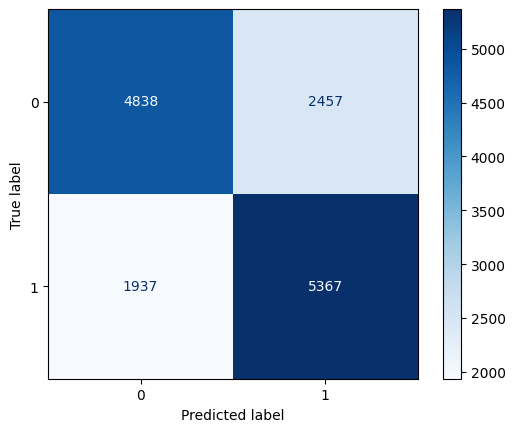

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")


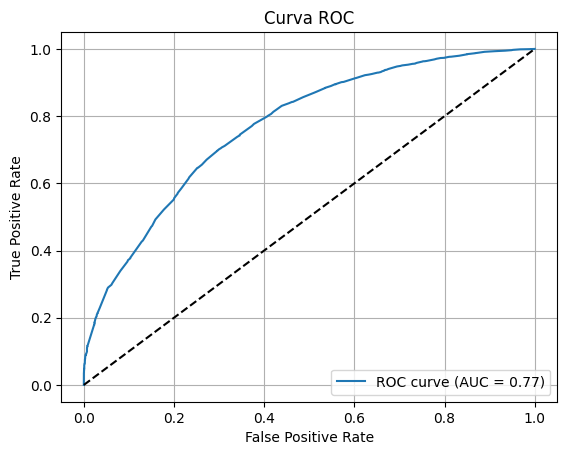

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()


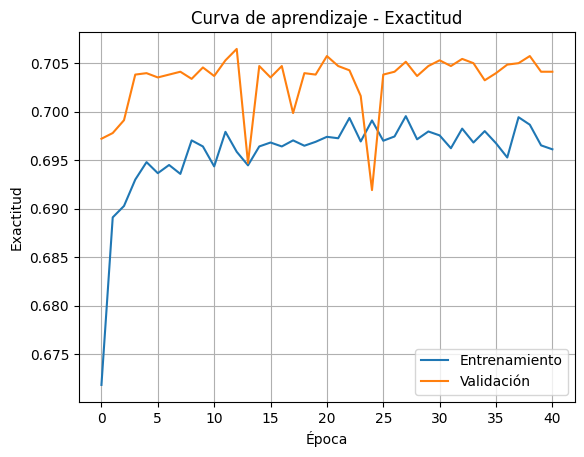

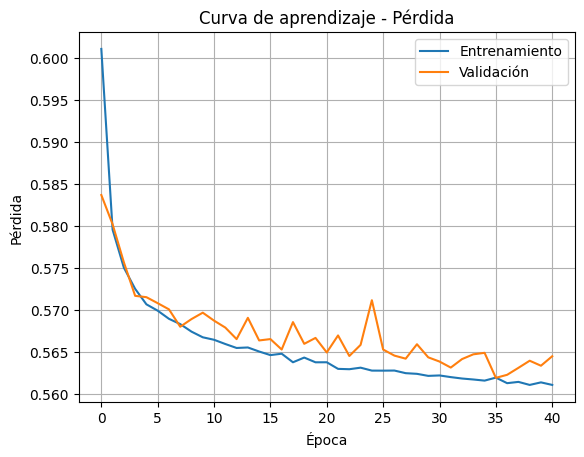

In [13]:
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.title('Curva de aprendizaje - Exactitud')
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curva de aprendizaje - Pérdida')
plt.legend()
plt.grid()
plt.show()


# Tarea 5

In [18]:
# Guardar modelo y escalador
joblib.dump(model, "modelo_entrenado.pkl")
joblib.dump(scaler, "scaler.pkl")



['scaler.pkl']

In [ ]:
# Cargar modelo y scaler
modelo = joblib.load("modelo_entrenado.pkl")
scaler = joblib.load("scaler.pkl") if os.path.exists("scaler.pkl") else None

# Cargar datos
df = pd.read_csv("Resultados_Saber11_2018.csv")

# Reconstrucción de columnas categóricas
def reconstruir_jornada(df):
    cols = ['COLE_JORNADA_MAÑANA', 'COLE_JORNADA_TARDE', 'COLE_JORNADA_UNICA']
    df['COLE_JORNADA'] = df[cols].idxmax(axis=1).str.replace('COLE_JORNADA_', '', regex=False)
    return df

def reconstruir_departamento(df):
    cols = [c for c in df.columns if c.startswith('ESTU_DEPTO_RESIDE_')]
    df['ESTU_DEPTO_RESIDE'] = df[cols].idxmax(axis=1).str.replace('ESTU_DEPTO_RESIDE_', '', regex=False)
    return df

df = reconstruir_jornada(df)
df = reconstruir_departamento(df)

app = dash.Dash(__name__)
server = app.server

# Layout
app.layout = html.Div([
    html.H1("🎓 Predicción de desempeño en Saber 11", style={'textAlign': 'center', 'marginBottom': '30px'}),

    html.Div([
        html.H3("📋 Ingrese la información del estudiante:"),

        html.Label("Edad:"),
        dcc.Input(id='input-edad', type='number', value=16),

        html.Br(), html.Label("Género:"),
        dcc.RadioItems(id='input-genero',
            options=[{'label': 'Hombre', 'value': 1}, {'label': 'Mujer', 'value': 0}],
            value=1,
            labelStyle={'display': 'inline-block', 'marginRight': '10px'}),

        html.Br(), html.Label("Área del colegio:"),
        dcc.Dropdown(id='input-area',
            options=[{'label': 'Urbano', 'value': 1}, {'label': 'Rural', 'value': 0}],
            value=1),

        html.Br(), html.Label("Carácter del colegio:"),
        dcc.RadioItems(id='input-caracter',
            options=[
                {'label': 'Técnico', 'value': 'tecnico'},
                {'label': 'Técnico/Académico', 'value': 'tecnico_academico'},
                {'label': 'Otro', 'value': 'otro'}
            ],
            value='tecnico',
            labelStyle={'display': 'inline-block', 'marginRight': '10px'}),

        html.Br(), html.Label("Jornada escolar:"),
        dcc.RadioItems(id='input-jornada',
            options=[
                {'label': 'Mañana', 'value': 'mañana'},
                {'label': 'Tarde', 'value': 'tarde'},
                {'label': 'Única', 'value': 'unica'}
            ],
            value='mañana',
            labelStyle={'display': 'inline-block', 'marginRight': '10px'}),

        html.Br(), html.Label("Departamento de residencia:"),
        dcc.Dropdown(id='input-departamento',
            options=[
                {'label': 'Bogotá', 'value': 'bogota'},
                {'label': 'Bolívar', 'value': 'bolivar'},
                {'label': 'Cundinamarca', 'value': 'cundinamarca'},
                {'label': 'Valle', 'value': 'valle'}
            ],
            value='bogota'),

        html.Br(),
        html.Button("🔍 Predecir desempeño", id='btn-predecir', n_clicks=0,
            style={'backgroundColor': '#3498db', 'color': 'white', 'padding': '10px'}),

        html.Div(id='output-prediccion', style={
            'marginTop': '20px', 'fontWeight': 'bold', 'fontSize': '18px'
        })
    ], style={
        'width': '50%', 'margin': 'auto', 'padding': '20px',
        'border': '1px solid #ccc', 'borderRadius': '10px', 'backgroundColor': '#f9f9f9'
    }),

    html.H3("📊 Visualizaciones interactivas", style={'textAlign': 'center'}),

    html.Div([
        dcc.Graph(id='grafico-histograma'),
        html.Hr(),
        dcc.Graph(id='grafico-jornada'),
        html.Hr(),
        dcc.Graph(id='grafico-departamentos')
    ], style={'width': '90%', 'margin': 'auto'})
])

# Callback predicción
@app.callback(
    Output('output-prediccion', 'children'),
    Input('btn-predecir', 'n_clicks'),
    State('input-edad', 'value'),
    State('input-genero', 'value'),
    State('input-area', 'value'),
    State('input-caracter', 'value'),
    State('input-jornada', 'value'),
    State('input-departamento', 'value')
)
def predecir(n_clicks, edad, genero, area, caracter, jornada, departamento):
    if n_clicks == 0:
        return ""

    entrada = {
        'EDAD': edad,
        'ESTU_GENERO_M': genero,
        'COLE_AREA_UBICACION_URBANO': area,
        'COLE_CARACTER_TÉCNICO': 1 if caracter == 'tecnico' else 0,
        'COLE_CARACTER_TÉCNICO/ACADÉMICO': 1 if caracter == 'tecnico_academico' else 0,
        'COLE_JORNADA_MAÑANA': 1 if jornada == 'mañana' else 0,
        'COLE_JORNADA_TARDE': 1 if jornada == 'tarde' else 0,
        'COLE_JORNADA_UNICA': 1 if jornada == 'unica' else 0,
        'ESTU_DEPTO_RESIDE_BOGOTÁ': 1 if departamento == 'bogota' else 0,
        'ESTU_DEPTO_RESIDE_BOLIVAR': 1 if departamento == 'bolivar' else 0,
        'ESTU_DEPTO_RESIDE_CUNDINAMARCA': 1 if departamento == 'cundinamarca' else 0,
        'ESTU_DEPTO_RESIDE_VALLE': 1 if departamento == 'valle' else 0
    }

    X_input = pd.DataFrame([entrada])
    prob = modelo.predict(scaler.transform(X_input))[0][0]
    resultado = "Desempeño Alto" if prob >= 0.5 else "Desempeño Bajo"
    return f"Probabilidad: {prob:.2f} — Resultado de predicción: {resultado}"

# Callback visualizaciones
@app.callback(
    Output('grafico-histograma', 'figure'),
    Output('grafico-jornada', 'figure'),
    Output('grafico-departamentos', 'figure'),
    Input('btn-predecir', 'n_clicks'),
    State('input-jornada', 'value'),
    State('input-departamento', 'value'),
    State('input-edad', 'value'),
    State('input-genero', 'value'),
    State('input-area', 'value'),
    State('input-caracter', 'value')
)
def actualizar_graficos(n, jornada, departamento, edad, genero, area, caracter):
    entrada = {
        'EDAD': edad,
        'ESTU_GENERO_M': genero,
        'COLE_AREA_UBICACION_URBANO': area,
        'COLE_CARACTER_TÉCNICO': 1 if caracter == 'tecnico' else 0,
        'COLE_CARACTER_TÉCNICO/ACADÉMICO': 1 if caracter == 'tecnico_academico' else 0,
        'COLE_JORNADA_MAÑANA': 1 if jornada == 'mañana' else 0,
        'COLE_JORNADA_TARDE': 1 if jornada == 'tarde' else 0,
        'COLE_JORNADA_UNICA': 1 if jornada == 'unica' else 0,
        'ESTU_DEPTO_RESIDE_BOGOTÁ': 1 if departamento == 'bogota' else 0,
        'ESTU_DEPTO_RESIDE_BOLIVAR': 1 if departamento == 'bolivar' else 0,
        'ESTU_DEPTO_RESIDE_CUNDINAMARCA': 1 if departamento == 'cundinamarca' else 0,
        'ESTU_DEPTO_RESIDE_VALLE': 1 if departamento == 'valle' else 0
    }
    df_input = pd.DataFrame([entrada])
    prob = modelo.predict(scaler.transform(df_input))[0][0]
    puntaje_estimado = prob * 500

    # Histograma con línea de predicción
    fig_hist = px.histogram(df, x="PUNT_GLOBAL", nbins=50, title="Distribución del Puntaje Global")
    fig_hist.add_vline(x=puntaje_estimado, line_dash="dash", line_color="red",
                       annotation_text="Tu predicción", annotation_position="top right")

    # Radar personalizado
    radar_cols = ["PUNT_MATEMATICAS", "PUNT_LECTURA_CRITICA", "PUNT_C_NATURALES",
                  "PUNT_SOCIALES_CIUDADANAS", "PUNT_INGLES"]
    promedio_nacional = df[radar_cols].mean()
    estudiante = promedio_nacional * prob  # Simulación ponderada

    radar_df = pd.DataFrame({
        "Áreas": radar_cols,
        "Promedio Nacional": promedio_nacional.values,
        "Estudiante": estudiante.values
    })

    fig_radar = px.line_polar(radar_df.melt(id_vars="Áreas"),
                              r='value', theta='Áreas',
                              color='variable', line_close=True,
                              title="Radar: Estudiante vs Nacional")

    # Violin plot por jornada
    fig_jornada = px.violin(df, x="COLE_JORNADA", y="PUNT_GLOBAL",
                            box=True, points="all", title="Distribución por Jornada")

    # Promedio por departamento
    df_dep = df.groupby("ESTU_DEPTO_RESIDE")["PUNT_GLOBAL"].mean().reset_index()
    fig_dep = px.bar(df_dep, x="ESTU_DEPTO_RESIDE", y="PUNT_GLOBAL", title="Promedio por Departamento")

    return fig_radar, fig_jornada, fig_dep

if __name__ == '__main__':
    app.run(debug=True)


1/1 [==============================] - 0s 14ms/step
